In [3]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [4]:

## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/"
iso = "Al" 
_path = datapath + "bananas/" + iso
_p_path = datapath +"bananaexplorer/" +iso
simpath = "/home/haue/repositories/Masters/simdata/"

#outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files = glob.glob(os.path.join(_path, "*mlio.root"))
_p_file = glob.glob(os.path.join(_p_path, "*mlio.root"))


In [37]:
#### Loading in of the data files storing them in a dictionary can be easily expanded to include multiple isotopes
#Could be done more optimally by doing it dynamically instead of this?
data_files = {
    iso: _files,
    "p_"+iso: _p_file,
}
data_collection = {
    iso : {},
    "p_"+iso : {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(4)} for isotope in data_files}

for isotope, files in data_files.items():
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Al: 100%|██████████ 56/56 [00:37<00:00,  1.48file/s]
Processing p_Al: 100%|██████████ 56/56 [00:17<00:00,  3.23file/s]


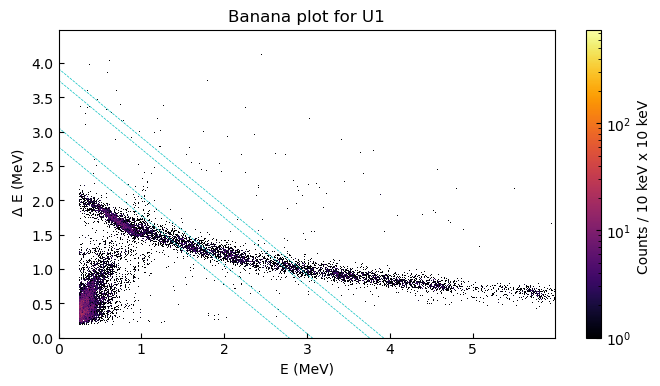

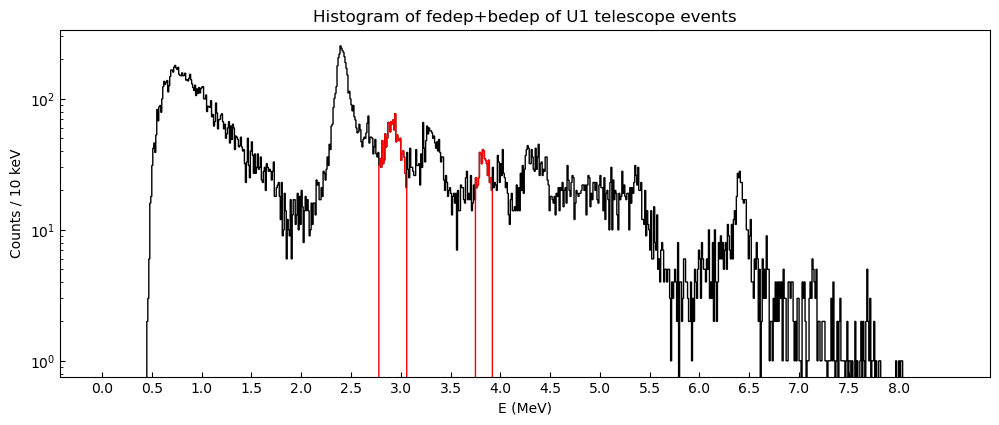

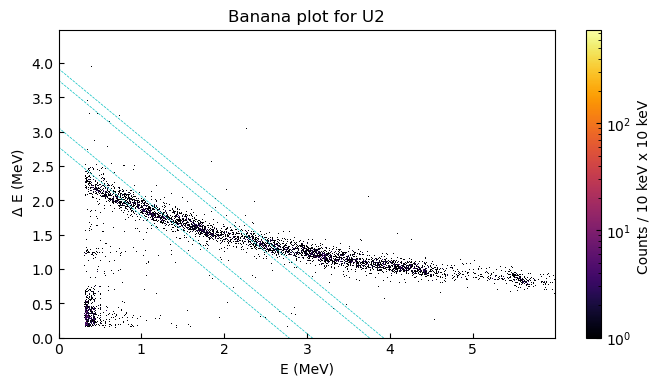

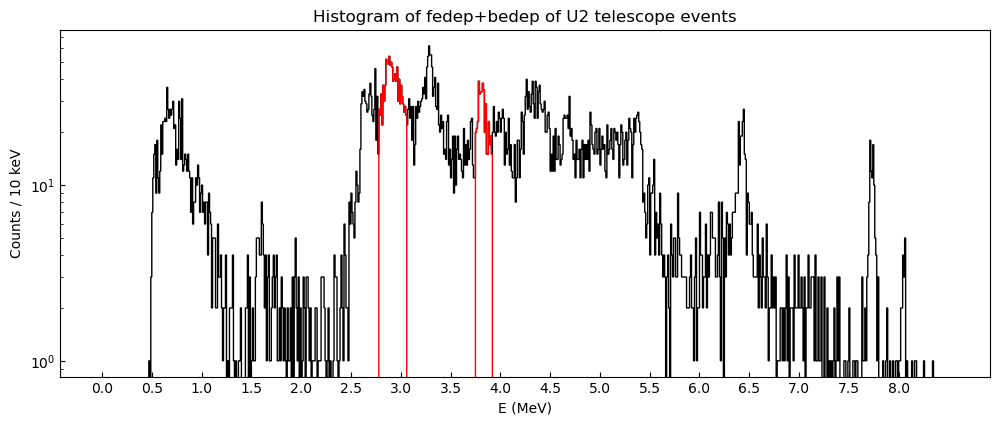

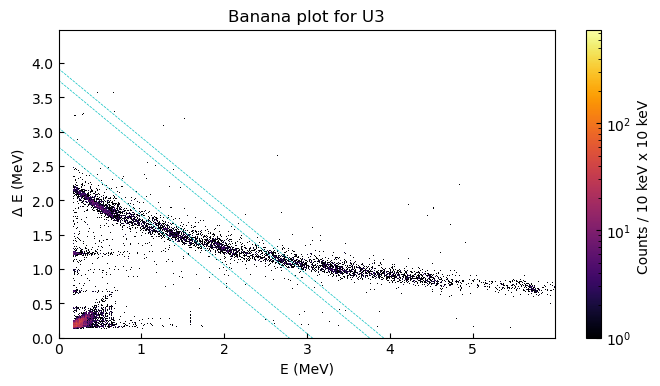

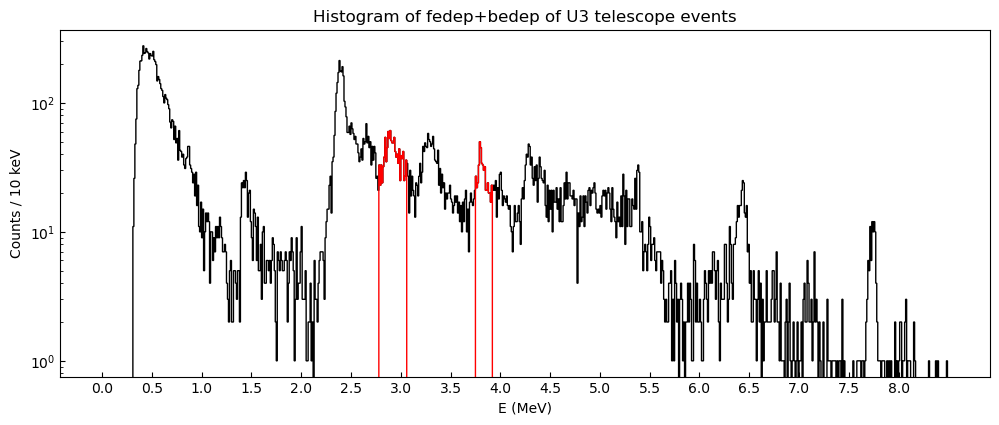

In [38]:

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"



lowlim = 2.78
uplim = 3.06
lowlim2= 3.75#4.14
uplim2 = 3.92#4.52

x = np.linspace(0, 6, 400)

y1 = -x + lowlim
y2 = -x + uplim 
y3 = -x + lowlim2
y4 = -x + uplim2 

### Banana plots to get an idea of the amount of events above the banana
## An idea of the size of the anomalous events
for i in range(3):
    det = f"id{i}"
    plt.figure(figsize=(8,4))
    plt.hist2d(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"], bins=(np.arange(0, 6, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)       
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel("E (MeV)")
    plt.ylabel(r" $\Delta$ E (MeV)")
    plt.title(f"Banana plot for U{i+1}")
    plt.plot(x,y1, ls='--', color='c', lw=0.5)
    plt.plot(x,y2, ls='--', color='c', lw=0.5)
    plt.plot(x,y3, ls='--', color='c', lw=0.5)
    plt.plot(x,y4, ls='--', color='c', lw=0.5)

    plt.plot()


    plt.figure(figsize=(12,4.5))
    æ = [a+b for a,b in zip(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"]) if a+b>0]
    plt.hist(æ, bins=np.arange(0,8.5,0.01), histtype='step', color='k')
    #plt.hist(data_collection[iso][det]["E"], bins=np.arange(0,8.5,0.01), histtype='step', color='k')

    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")
    plt.yscale('log')
    plt.title(f"Histogram of fedep+bedep of U{i+1} telescope events")
    ø = [i for i in æ if lowlim<i<uplim]
    plt.hist(ø, bins=np.arange(0,8.5,0.01), histtype='step', color='r')
    å = [i for i in æ if lowlim2<i<uplim2]
    plt.hist(å, bins=np.arange(0,8.5,0.01), histtype='step', color='r')
    plt.xticks(np.arange(0,8.5,0.5))
    #plt.hist(data_collection[iso][det]["Edep"], bins=np.arange(0,8.5,0.01), histtype='step', color='c')
    #plt.vlines(2.99, 0, 1e2, color='c', ls='--')
    #plt.vlines(3.877, 0, 1e2, color='c', ls='--')
    plt.show()


In [39]:
### Could be better implemented to be able to handle n amount of peaks, this could be done like the data is loaded
## or like a class where one can draw different figures like done in the below cells through very few clicks, that would honestly be great
# should be that one instantiates a class by stating the detector id, im not sure i can read in all isotopes at once since the memory usage will be too great. Another way to do it would simply
# be when instantiating a class it loads in the files of the specified isotope, however each call of the class will be slow.

### Extract the two zones specified in the above figures:
p1_fi =[[_] for _ in range(3)]; p1_bi=[[_] for _ in range(3)]; p1_fedep=[[_] for _ in range(3)]
p1_bedep=[[_] for _ in range(3)]; p1_a=[[_] for _ in range(3)]; p1_angs=[[_] for _ in range(3)]
p1_f=[[_] for _ in range(3)]
p1_angs_fi=[[_] for _ in range(3)];p1_angs_bi=[[_] for _ in range(3)]
p2_fi =[[_] for _ in range(3)]; p2_bi=[[_] for _ in range(3)]; p2_fedep=[[_] for _ in range(3)]
p2_bedep=[[_] for _ in range(3)]; p2_a=[[_] for _ in range(3)]; p2_angs=[[_] for _ in range(3)]
p2_f=[[_] for _ in range(3)]
p2_angs_fi=[[_] for _ in range(3)];p2_angs_bi=[[_] for _ in range(3)]##uhm should be same length but for some reason not..

##Peaks we want to analyze
p1 = 2.99
p2 = 3.877

for i in range(3):
    det = f"id{i}"
    
    for a,b,c,d,v in zip(data_collection[iso][det]["fEdep"], data_collection[iso][det]["bEdep"],
                       data_collection[iso][det]["FI"], data_collection[iso][det]["BI"],data_collection[iso][det]["angle"]):
        if lowlim<=a+b<=uplim:
            p1_fi[i].append(c)
            p1_bi[i].append(d)
            p1_fedep[i].append(a)
            p1_bedep[i].append(b)
            p1_a[i].append(v)
        elif lowlim2<=a+b<=uplim2:
            p2_fi[i].append(c)
            p2_bi[i].append(d)
            p2_fedep[i].append(a)
            p2_bedep[i].append(b)
            p2_a[i].append(v)
        else:
            continue
            ###### So the above for loop is one way of iterating over values and putting them into the desired
            ###### arrays, however the below way is most likely a better implementation
            ## should redo
    p1_angs[i] = [v for v,vf,vb in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"]) if lowlim<=vf+vb<=uplim]#and v>0]
    p2_angs[i] = [v for v,vf,vb in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"]) if lowlim2<=vf+vb<=uplim2] #and v>0]
    p1_f[i] = [a for v,a,b in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"]) if lowlim<=a+b<=uplim]# and v>0]
    p1_angs_fi[i] = [F for v,a,b,F,B in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"], data_collection["p_"+iso][det]["FI"],
                   data_collection["p_"+iso][det]["BI"]) if lowlim<=a+b<=uplim]# and v>
    p1_angs_bi[i] = [B for v,a,b,F,B in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"], data_collection["p_"+iso][det]["FI"],
                   data_collection["p_"+iso][det]["BI"]) if lowlim<=a+b<=uplim]# and v>
    p2_f[i] = [a for v,a,b in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"]) if lowlim2<=a+b<=uplim2]# and v>0] 
    p2_angs_fi[i] = [F for v,a,b,F,B in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"], data_collection["p_"+iso][det]["FI"],
                   data_collection["p_"+iso][det]["BI"]) if lowlim2<=a+b<=uplim2]# and v>
    p2_angs_bi[i] = [B for v,a,b,F,B in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"], data_collection["p_"+iso][det]["FI"],
                   data_collection["p_"+iso][det]["BI"]) if lowlim2<=a+b<=uplim2]# and v>


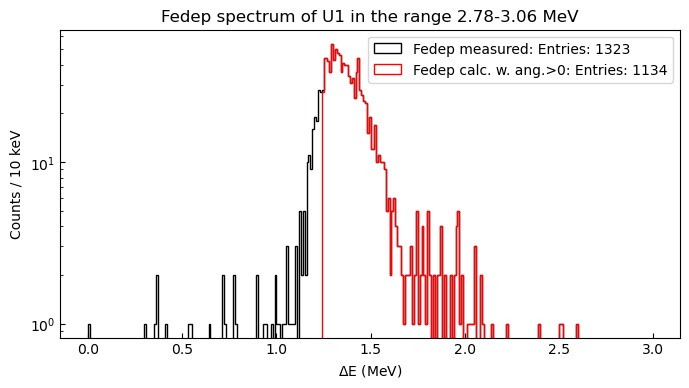

1.2404284223247415


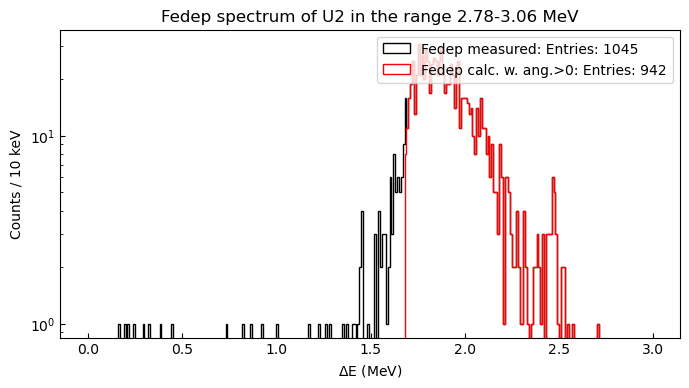

1.685846873515557


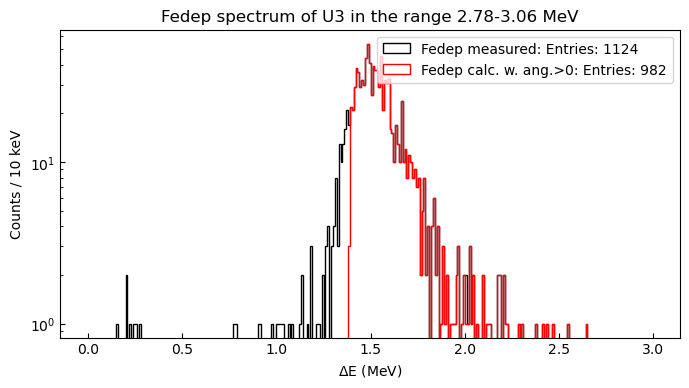

1.3898565677281076


In [40]:
for i in range(3):
    plt.figure(figsize=(8,4))
    plt.xlabel(r"$\Delta$E (MeV)")
    plt.ylabel("Counts / 10 keV")
    plt.yscale('log')
    calc_fedeps = [a for a,v in zip(p1_f[i],p1_angs[i]) if v>0] 
    plt.title(f"Fedep spectrum of U{i+1} in the range {lowlim}-{uplim} MeV")
    plt.hist(p1_fedep[i], bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured: Entries: {len(p1_fedep[i])}")
    plt.hist(calc_fedeps, bins=np.arange(0,3, 0.01), histtype='step', color='r', label=f"Fedep calc. w. ang.>0: Entries: {len(calc_fedeps)}")#({len(p1_f[i])/len(p1_fedep[i])*100:.2f}%)")
    plt.legend()
    plt.show()
    print(np.min(calc_fedeps))

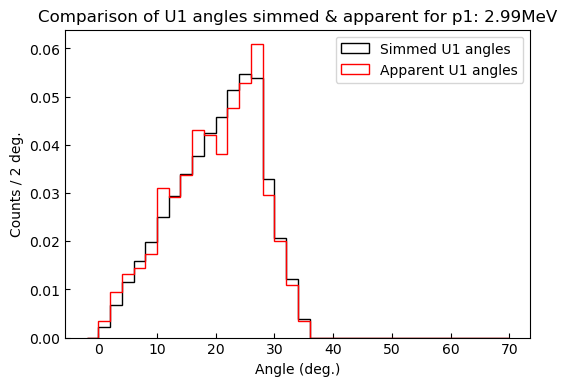

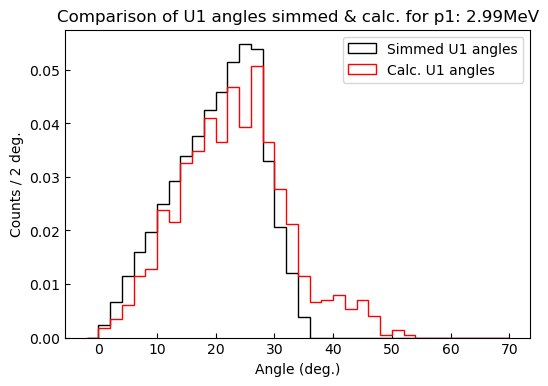

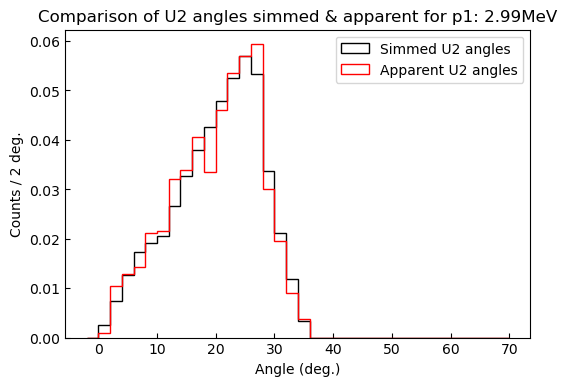

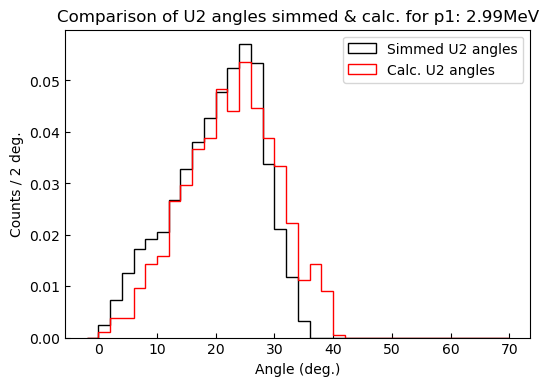

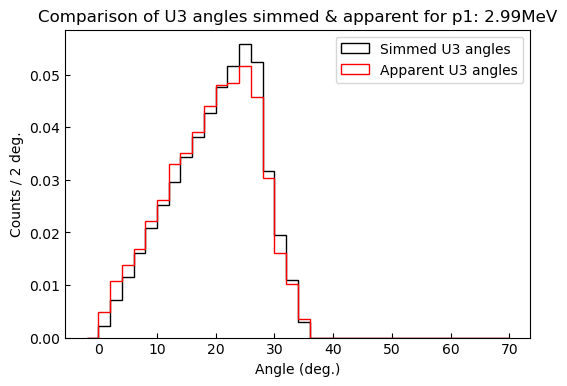

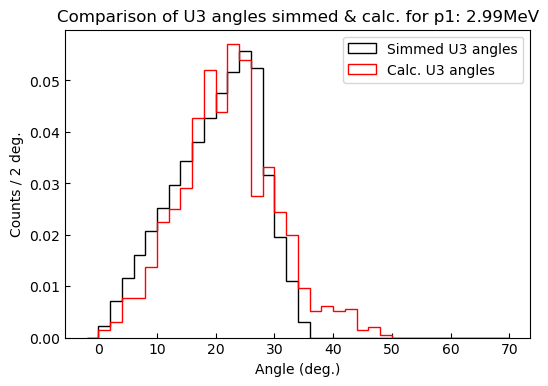

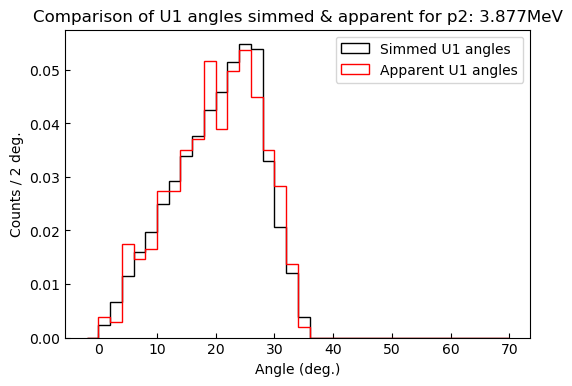

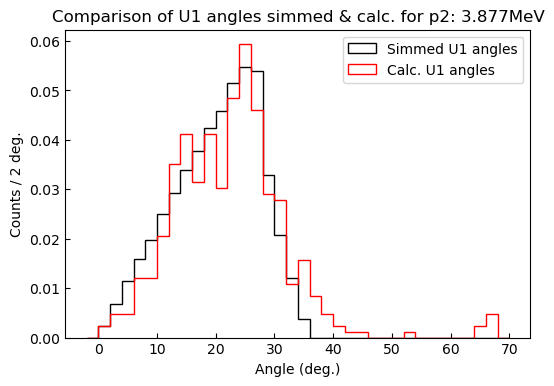

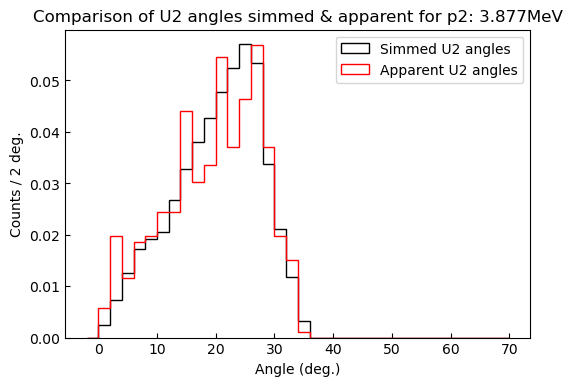

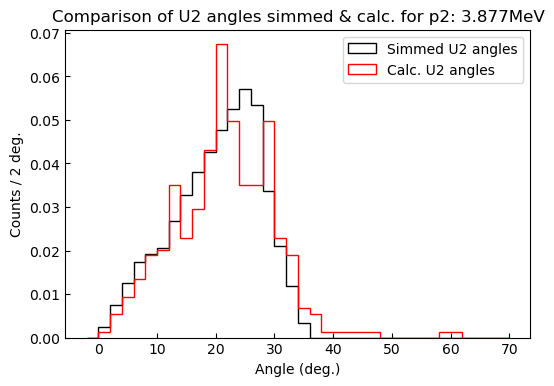

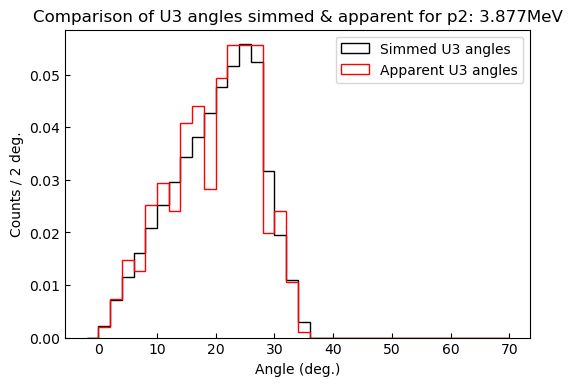

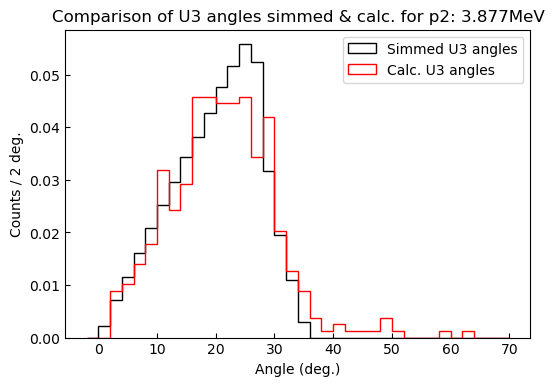

In [41]:
angfiles = ["U1Ang.dat", "U2Ang.dat", "U3Ang.dat"]
labs = ["U1 angles", "U2 angles", "U3 angles"]
### can expand to multiple peaks

for pas, pangs, p in zip([p1_a, p2_a], [p1_angs,p2_angs], ["p1: 2.99MeV", "p2: 3.877MeV"]):
    for i, a, l in zip(range(3),angfiles,labs):
        plt.figure(figsize=(6,4))
        plt.xlabel("Angle (deg.)")
        plt.ylabel("Counts / 2 deg.")
        fi, bi, angs, n = np.loadtxt(simpath+a, unpack=True)
        angs = np.rad2deg(angs)
        angs = [a for a,f,b in zip(angs, fi, bi) if f>1 and f<16 and b>1 and b<16]
        plt.hist(angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True, label="Simmed "+l)
        plt.hist(pas[i], bins=np.arange(-2,72,2), histtype='step', color='r', density=True, label="Apparent "+l)
        plt.legend()
        plt.title(f"Comparison of " +l + f" simmed & apparent for {p}")
        ###
        plt.figure(figsize=(6,4))
        plt.xlabel("Angle (deg.)")
        plt.ylabel("Counts / 2 deg.")
        p1a = [a for a in pangs[i] if a>0]
        plt.hist(angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True, label="Simmed "+l)
        plt.hist(p1a, bins=np.arange(-2,72,2), histtype='step', color='r', density=True, label="Calc. "+l)
        plt.legend()
        plt.title(f"Comparison of " +l + f" simmed & calc. for {p}")


17101
16647
17612


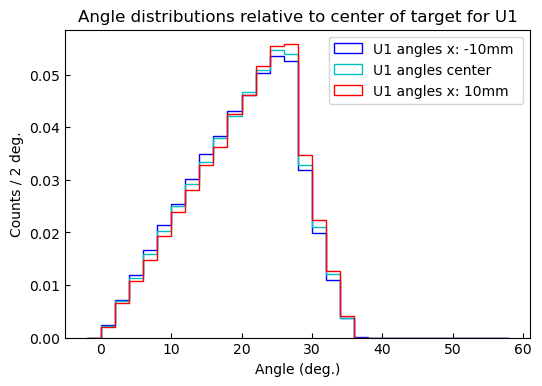

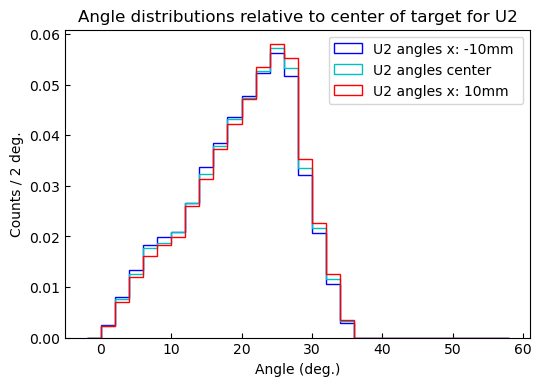

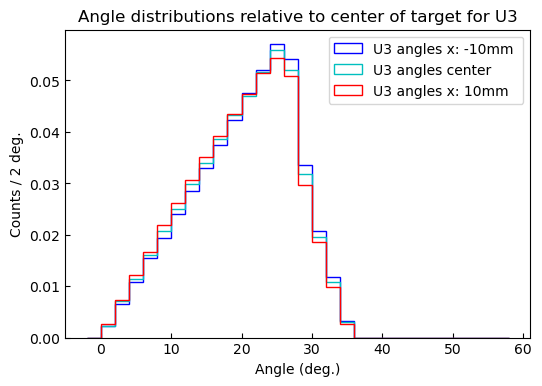

In [42]:
import subprocess
xs = [-10, 0, 10]
ys = [-10, 0, 10]
xy = [0, -7.1]
simdir = "/home/haue/repositories/Masters/simdata/"
angles = [[[] for _ in range(3)] for _ in range(3)]
FI_list = [[[] for _ in range(3)] for _ in range(3)]
BI_list = [[[] for _ in range(3)] for _ in range(3)]
cols = ['b', 'c', 'r']
cm = 1
var = "x"
for i in range(3):
    curdir = os.getcwd()
    os.chdir(simdir)    
    for x,j in zip(xs,range(len(xs))):
        filename = "U%dang_%d%s.dat" % (i+1, int(x), var)
        if not os.path.exists(filename):
            f = open(filename, "w")
            subprocess.call(["Angles", "-dU%d" % (i+1), f"-i41", "-ssetup.json", "-ttarget.json", "-mmatcher.json"
                                , "-n 1000", "-%s%d" % (var,x)], cwd="/home/haue/repositories/Masters/setup/", stdout=f)
            f.close()
        fi, bi, angs, n = np.loadtxt(filename, unpack=True)
        angs = np.rad2deg(angs)
        angs = [a for a,f,b in zip(angs, fi, bi) if f>1 and f<16 and b>1 and b<16]
        angles[i][j].append(angs)
        ##### Loop to generate hit pattern lists of FI and BI
        for æ in range(2,16): #we exclude FI=1 and FI =16
            mask_fi = (fi==æ)
            if not np.any(mask_fi):
                continue
            else:
                masked_fi = fi[mask_fi]
                masked_bi = bi[mask_fi]
                masked_n = n[mask_fi]
            for ø in range(2,16): #we exclude BI=1 and BI=16
                mask_bi = (masked_bi == ø)       
                if not np.any(mask_bi):
                    continue
                else:   
                    doubmasked_n = masked_n[mask_bi] ## list of n's, they should all have the same value
                    for å in range(0,int(doubmasked_n[0])):
                        FI_list[i][j].append(æ)
                        BI_list[i][j].append(ø)     
    os.chdir(curdir)

### To plot it non relative just remove the plt.hist bin edges thingy 
## And if one wants to see the normalized just add density=True

for i in range (3):
    labs = [f"U{i+1} angles {var}: {xs[0]}mm ", f"U{i+1} angles center", f"U{i+1} angles {var}: {xs[2]}mm"]
    hist1, _ = np.histogram(angles[i][1], bins=(np.arange(-2,60,2)))
    max_a_cent = np.max(hist1)
    print(max_a_cent)
    plt.figure(figsize=(6,4))
    plt.xlabel("Angle (deg.)")
    plt.ylabel("Counts / 2 deg.")
    plt.title(f"Angle distributions relative to center of target for U{i+1}")
    for j,c,l in zip(range(3),cols,labs):
        rel_hist, bin_edges = np.histogram(angles[i][j], bins=(np.arange(-2,60,2)))
        rel_hist = rel_hist/max_a_cent
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        #plt.hist(bin_edges[:-1], bins=bin_edges, weights=rel_hist, histtype='step', color=c, label=l)
        plt.hist(angles[i][j], bins=np.arange(-2,60,2), histtype='step', density=True, color=c, label=l)
        plt.legend()
    


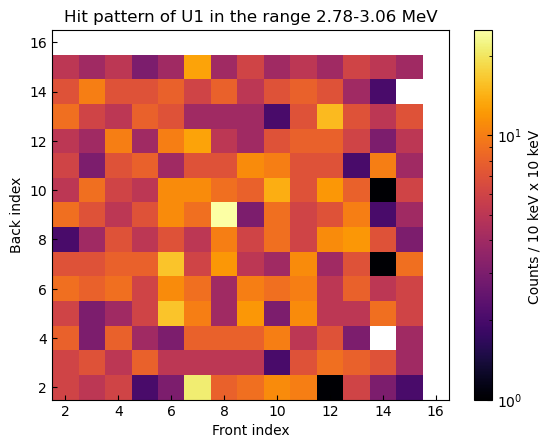

In [43]:
plt.figure()
plt.hist2d(p1_fi[0], p1_bi[0], bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)

plt.title(f"Hit pattern of U1 in the range {lowlim}-{uplim} MeV")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')
plt.show()

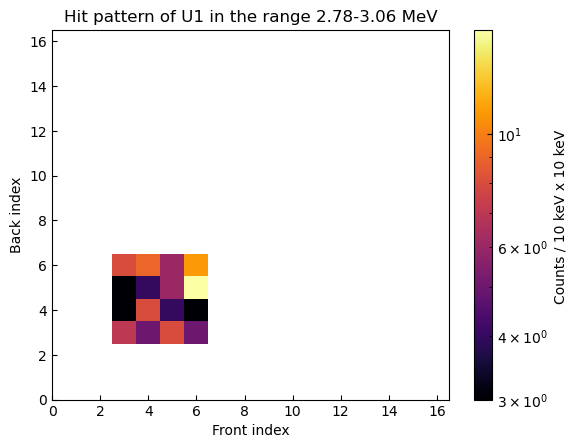

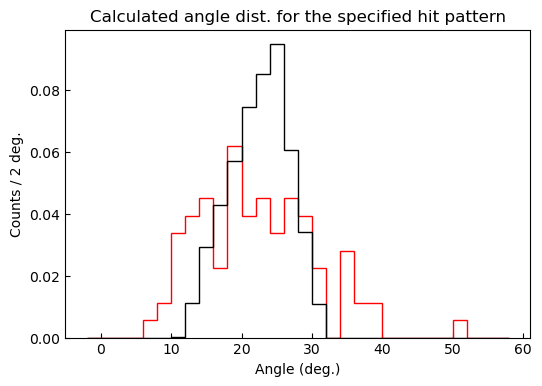

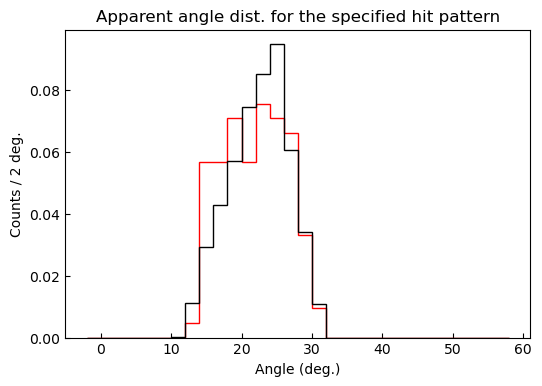

NEW HIT COMBINATION OF FI & BI


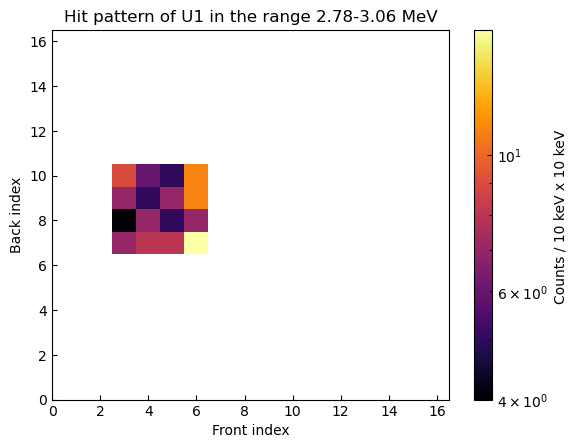

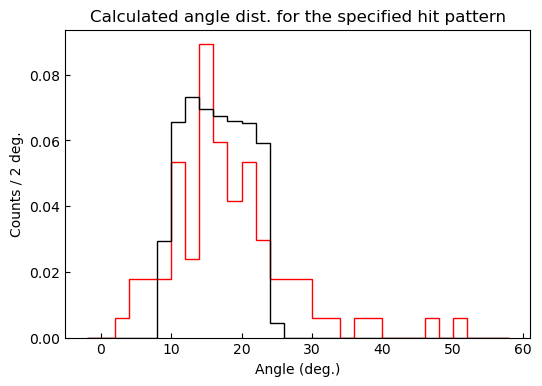

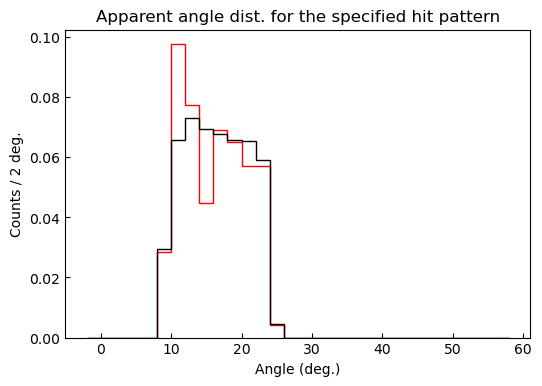

NEW HIT COMBINATION OF FI & BI


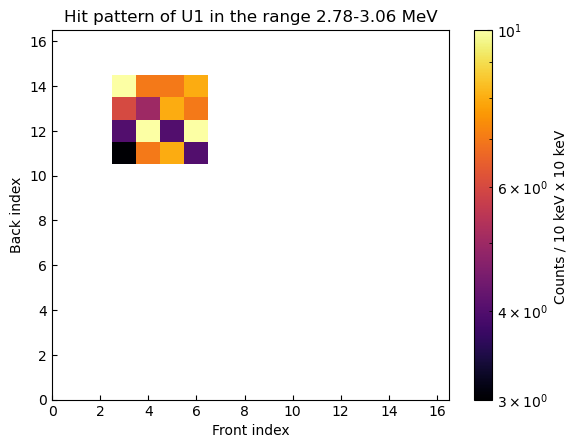

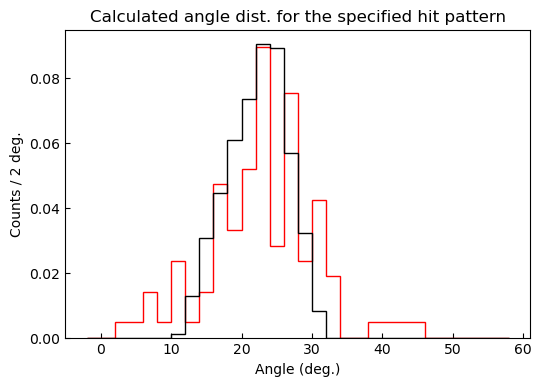

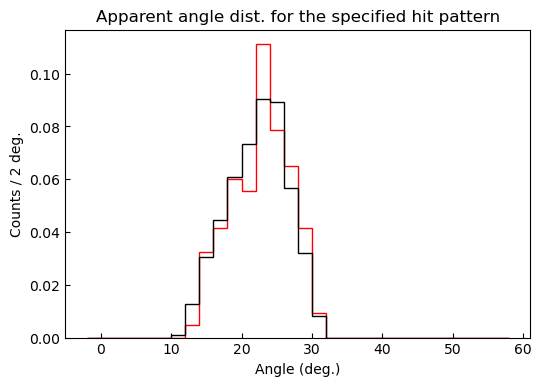

NEW HIT COMBINATION OF FI & BI


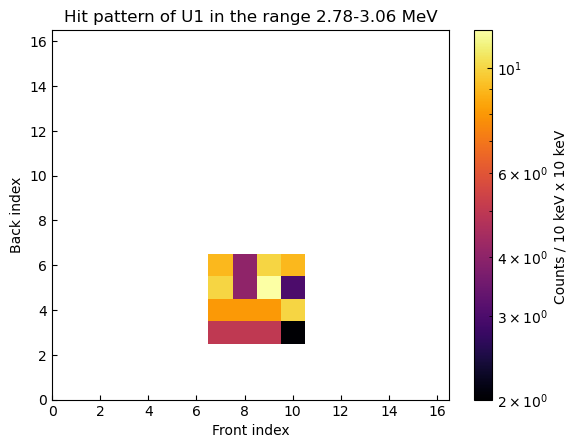

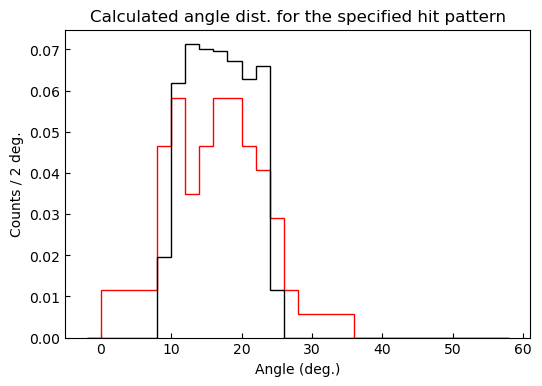

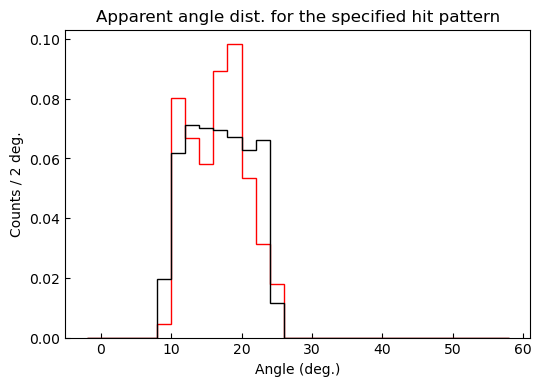

NEW HIT COMBINATION OF FI & BI


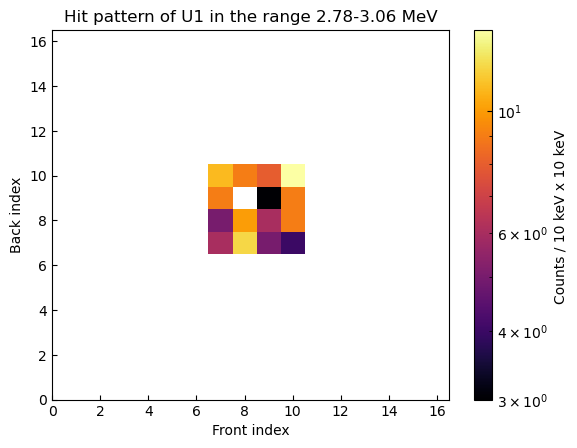

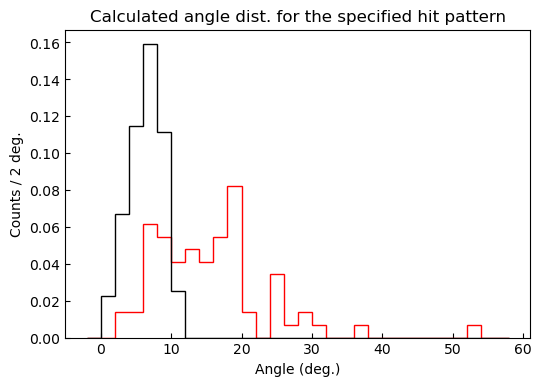

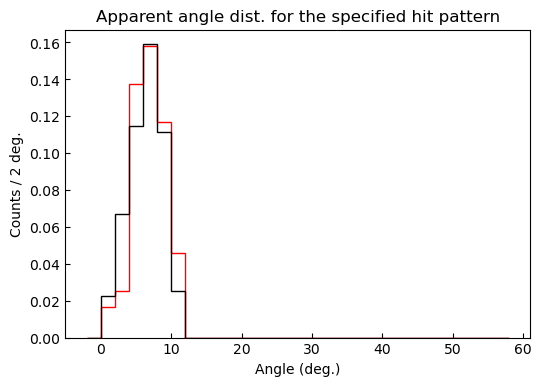

NEW HIT COMBINATION OF FI & BI


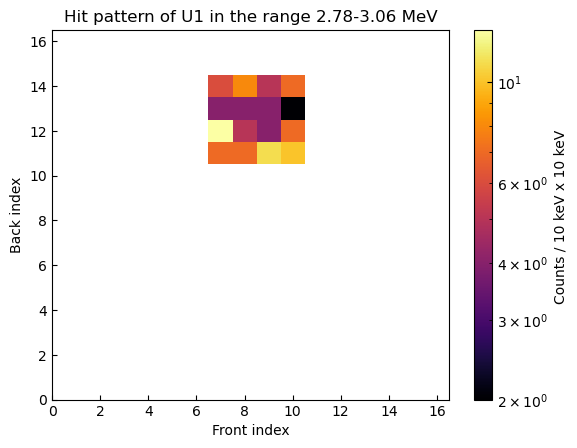

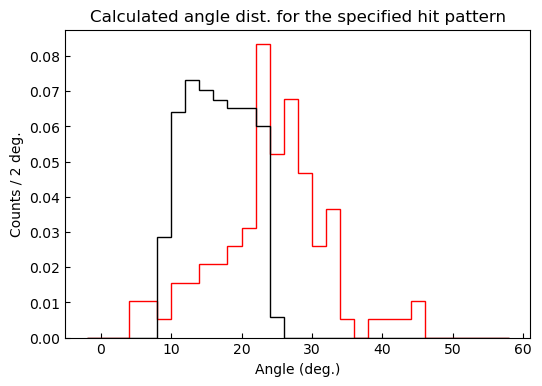

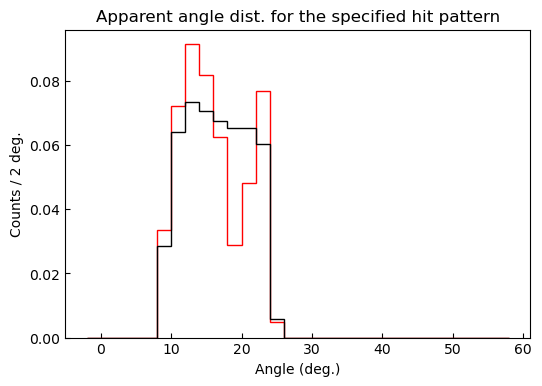

NEW HIT COMBINATION OF FI & BI


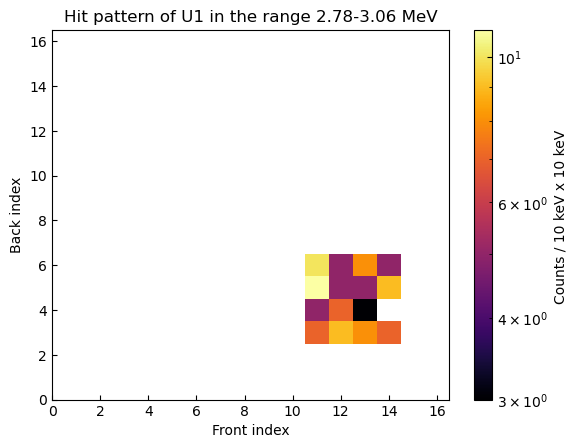

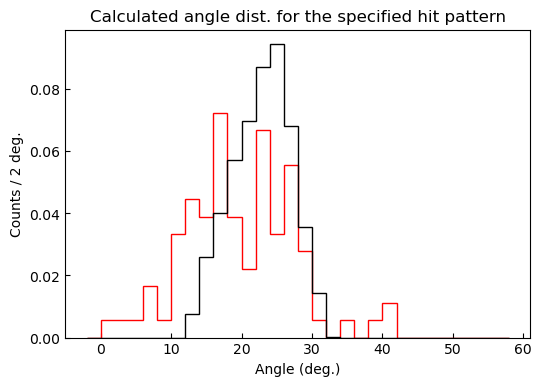

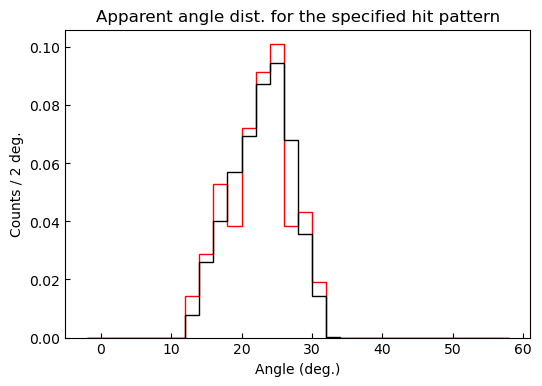

NEW HIT COMBINATION OF FI & BI


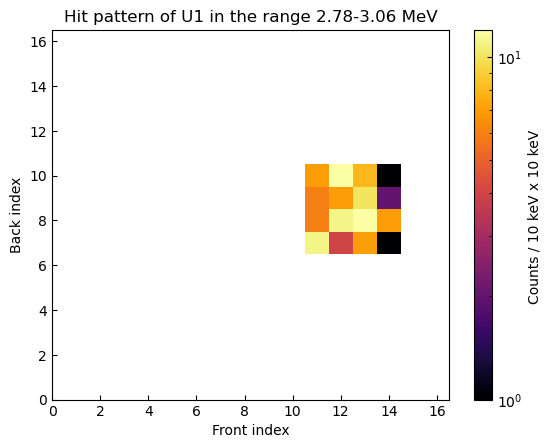

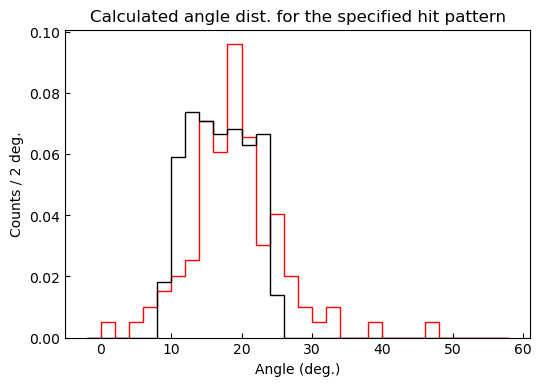

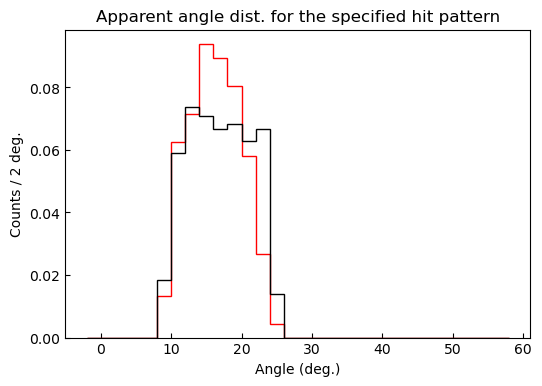

NEW HIT COMBINATION OF FI & BI


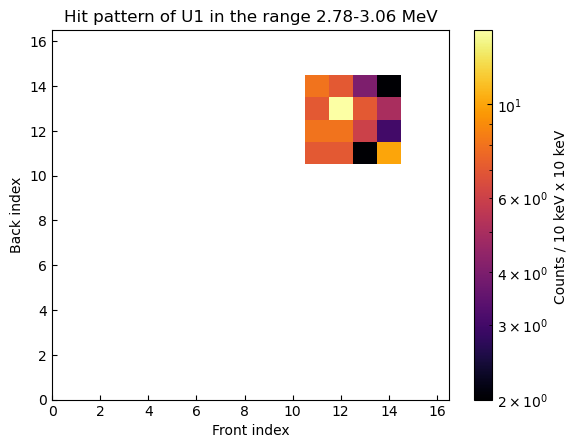

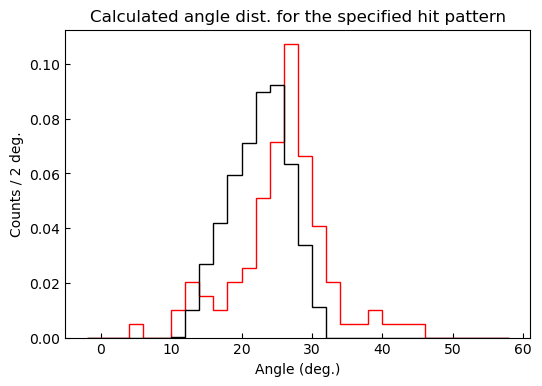

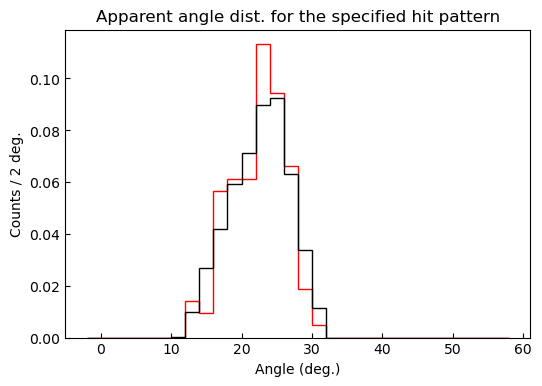

NEW HIT COMBINATION OF FI & BI


In [44]:
limits = [(2,7), (6,11), (10,15)]
for f in limits:
    for b in limits:

        cent_a = np.array(p1_angs[0])
        cent_f = np.array(p1_angs_fi[0])
        mf = (f[0]<cent_f) & (cent_f<f[1])
        cent_f = cent_f[mf]
        cent_b = np.array(p1_angs_bi[0])
        cent_b = cent_b[mf]
        cent_a = cent_a[mf]
        mb = (b[0]<cent_b) & (cent_b<b[1])
        cent_f = cent_f[mb]
        cent_b = cent_b[mb]
        cent_a = cent_a[mb]

        c_f = [f for f, b in zip(cent_f, cent_b) if not (f == 8 and b == 9)]
        c_b = [b for f, b in zip(cent_f, cent_b) if not (f == 8 and b == 9)]
        c_a = [a for f,b,a in zip(cent_f,cent_b,cent_a) if not (f == 8 and b == 9)]

        plt.figure()
        #plt.hist2d(p1_fi[0], p1_bi[0], bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
        #cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
        plt.hist2d(c_f, c_b, bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
            cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
        plt.title(f"Hit pattern of U1 in the range {lowlim}-{uplim} MeV")
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
        plt.xlabel('Front index')
        plt.ylabel('Back index')
        plt.xticks(np.arange(0,18, 2))
        plt.yticks(np.arange(0,18,2))

        plt.figure(figsize=(6,4))
        plt.xlabel("Angle (deg.)")
        plt.ylabel("Counts / 2 deg.")
        #print("length before a>0 cut", len(cent_a))
        cent_a = [a for a in c_a if a>0]
        #print("length after a>0 cut", len(cent_a))
        plt.hist(cent_a, bins=np.arange(-2,60,2), histtype='step', color='r', density=True)
        plt.title("Calculated angle dist. for the specified hit pattern")
        
        fi, bi, angs, n = np.loadtxt(simpath+"U1Ang.dat", unpack=True)
        angs = np.rad2deg(angs)
        angs = [a for a,fs,bs in zip(angs, fi, bi) if fs>f[0] and fs<f[1] and bs>b[0] and bs<b[1]]
        plt.hist(angs, bins=np.arange(-2,60,2), histtype='step', color='k', density=True, label="Simmed ")
        
        plt.show()



        ##########################
        cent_a = np.array(p1_a[0])
        cent_f = np.array(p1_fi[0])
        mf = (f[0]<cent_f) & (cent_f<f[1])
        cent_f = cent_f[mf]
        cent_b = np.array(p1_bi[0])
        cent_b = cent_b[mf]
        cent_a = cent_a[mf]
        mb = (b[0]<cent_b) & (cent_b<b[1])
        cent_f = cent_f[mb]
        cent_b = cent_b[mb]
        cent_a = cent_a[mb]

        c_a = [a for f,b,a in zip(cent_f,cent_b,cent_a) if not (f == 8 and b == 9)]


        plt.figure(figsize=(6,4))
        plt.xlabel("Angle (deg.)")
        plt.ylabel("Counts / 2 deg.")

        cent_a = [a for a in c_a if a>0]
        plt.hist(cent_a, bins=np.arange(-2,60,2), histtype='step', color='r', density=True)
        plt.title("Apparent angle dist. for the specified hit pattern")
        plt.hist(angs, bins=np.arange(-2,60,2), histtype='step', color='k', density=True, label="Simmed ")
        plt.show()
        print("NEW HIT COMBINATION OF FI & BI")



In [45]:
m = 0.00538362
oo = 0.00265358
so = 0.0027313
os = 0.00262634
ss = 0.00264555

oo/m*1000, so/m*1000, os/m*1000, ss/m*1000
l = [0.56, 0.61, 0.64, 0.68, 0.69, 0.74]
np.rad2deg(l)

array([32.08563653, 34.9504255 , 36.66929889, 38.96113007, 39.53408786,
       42.39887684])

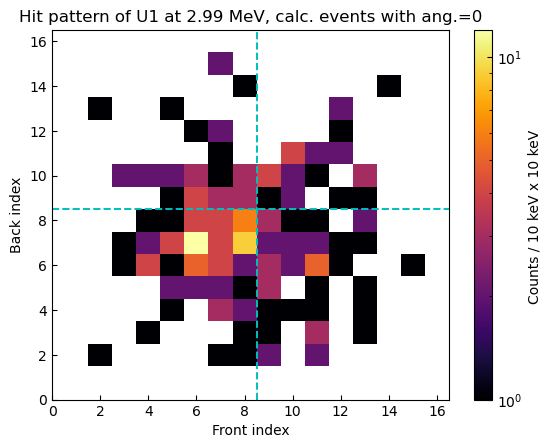

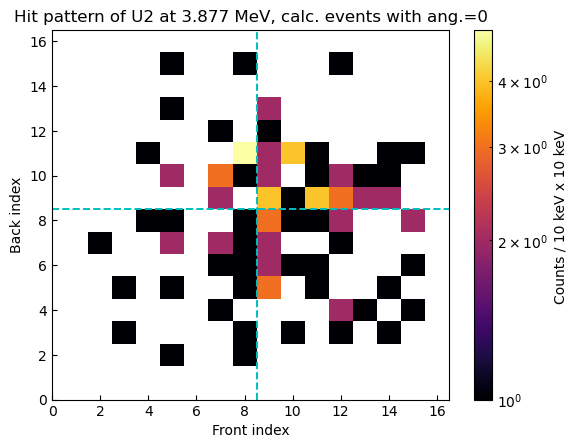

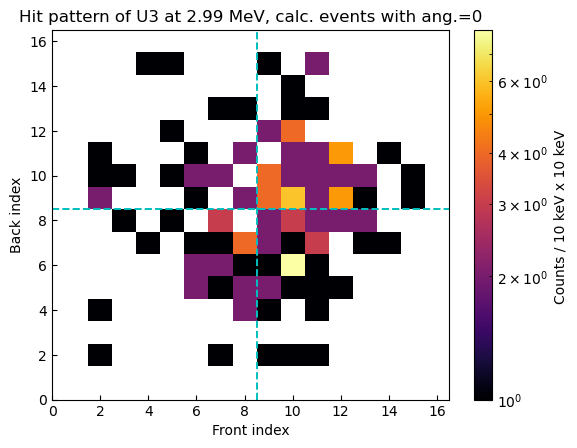

In [47]:
ps = [p1_angs[0], p1_angs[1], p1_angs[2]]
ps_fi = [p1_angs_fi[0], p1_angs_fi[1], p1_angs_fi[2]]
ps_bi = [p1_angs_bi[0], p1_angs_bi[1], p1_angs_bi[2]]
peaks = [2.99, 3.877, 2.99]
for i in range(3):
    calc_angles = np.array(ps[i])#p1_angs[i])
    mask = (calc_angles ==0)
    fs = np.array(ps_fi[i])#p1_angs_fi[i])
    bs = np.array(ps_bi[i])#p1_angs_bi[i])
    fs = fs[mask]
    bs = bs[mask]
    plt.figure()
    #plt.hist2d(p1_fi[0], p1_bi[0], bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
    #cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.hist2d(fs, bs, bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
        cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern of U{i+1} at {peaks[i]} MeV, calc. events with ang.=0")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    plt.xticks(np.arange(0,18, 2))
    plt.yticks(np.arange(0,18,2))
    plt.vlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')
    plt.hlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')

    plt.show()


In [118]:
np.sqrt(39.9**2+29.9**2), np.sqrt(19.9**2+29.9**2)

(49.86000401123129, 35.91684841407998)

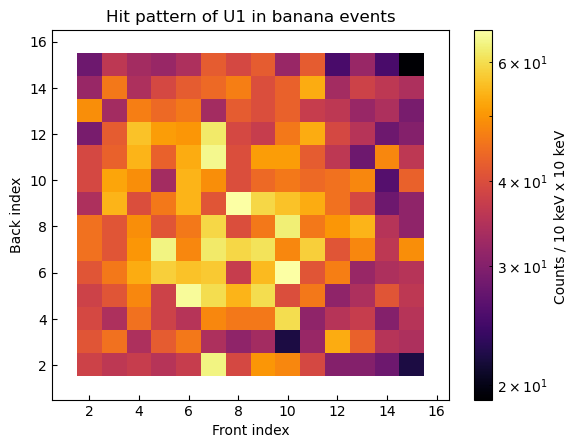

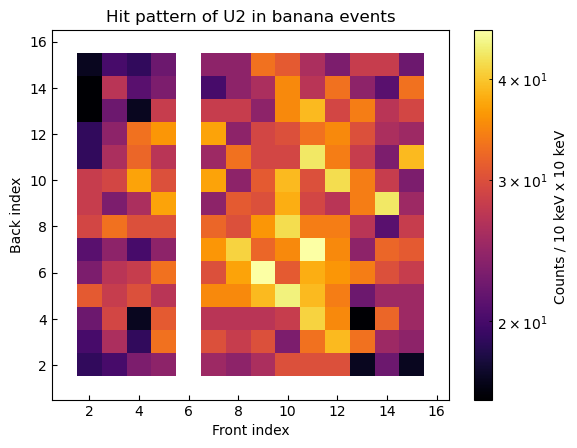

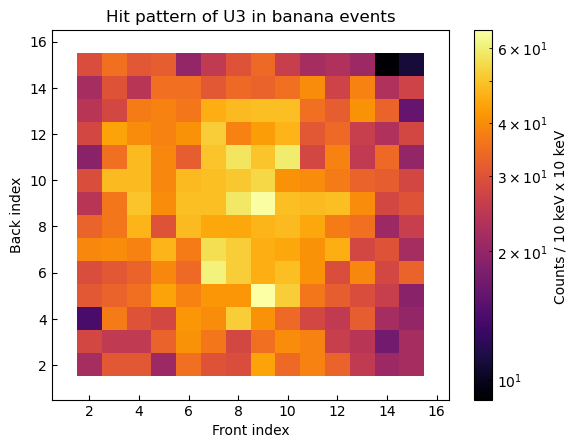

In [222]:
cuts1 = datapath + "cuts/totcuts.root"

totcuts = uproot.open(cuts1)
lims = [2.75, 3.3, 2.8]

for i in range(3):
    xb, yb = totcuts[f"bananaU{i+1}"].values()
    xb = xb/1e3
    yb = yb/1e3

    
    inbanana = np.column_stack((xb, yb))#(iis[0], js[0]))
    inbanana_path = Path(inbanana)
    det = f"id{i}"
    points = np.column_stack((data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"]))
    inmask = inbanana_path.contains_points(points)

    in_bi = np.array(data_collection[iso][det]["BI"])[inmask]
    in_fi = np.array(data_collection[iso][det]["FI"])[inmask]
    in_fedep = np.array(data_collection[iso][det]["fEdep"])[inmask]
    in_bedep = np.array(data_collection[iso][det]["bEdep"])[inmask]
    in_E = np.array(data_collection[iso][det]["E"])[inmask]
    ################################
    Emask = (in_fedep+in_bedep>lims[i])
    ################################
    in_fi = in_fi[Emask]
    in_bi = in_bi[Emask]
    
    plt.hist2d(in_fi,in_bi, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
        cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern of U{i+1} in banana events")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    plt.show()

In [252]:
#### Can be used to visualize the angle distribution of the simulated events
## Shows the net effect of the noncentralization of the detector to the implantation location
"""


limits = [(0,5), (4,9), (8,13), (12,17)]
for l in limits:
    for k in limits:
        plt.figure()
        fi, bi, angs, n = np.loadtxt(simpath+"U1Ang.dat", unpack=True)
        angs = np.rad2deg(angs)
        filt_angs = [a for a,fs,bs in zip(angs, fi, bi) if fs>l[0] and fs<l[1] and bs>k[0] and bs<k[1]]
        plt.hist(filt_angs, bins=np.arange(-2,60,2), histtype='step', color='k', density=True, label="Simmed ")
        
        plt.figure()
        fas = [fs for a, fs, bs in zip(angs, fi, bi) if fs>l[0] and fs<l[1] and bs>k[0] and bs<k[1]]
        bas = [bs for a, fs, bs in zip(angs, fi, bi) if fs>l[0] and fs<l[1] and bs>k[0] and bs<k[1]]
        plt.hist2d(fas, bas, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
        cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
        plt.xlabel('Front index')
        plt.ylabel('Back index')
"""

'\n\n\nlimits = [(0,5), (4,9), (8,13), (12,17)]\nfor l in limits:\n    for k in limits:\n        plt.figure()\n        fi, bi, angs, n = np.loadtxt(simpath+"U1Ang.dat", unpack=True)\n        angs = np.rad2deg(angs)\n        filt_angs = [a for a,fs,bs in zip(angs, fi, bi) if fs>l[0] and fs<l[1] and bs>k[0] and bs<k[1]]\n        plt.hist(filt_angs, bins=np.arange(-2,60,2), histtype=\'step\', color=\'k\', density=True, label="Simmed ")\n        \n        plt.figure()\n        fas = [fs for a, fs, bs in zip(angs, fi, bi) if fs>l[0] and fs<l[1] and bs>k[0] and bs<k[1]]\n        bas = [bs for a, fs, bs in zip(angs, fi, bi) if fs>l[0] and fs<l[1] and bs>k[0] and bs<k[1]]\n        plt.hist2d(fas, bas, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),\n        cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)\n        cbar = plt.colorbar()\n        cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")\n        plt.xlabel(\'Front index\')\n        plt.ylabel(\'Back index\')\n'

In [20]:
"""
for i in range(3):
    for j in range(3):
        plt.figure()
        plt.hist2d(np.array(FI_list[i][j])-0.5, np.array(BI_list[i][j])-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
        cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
        plt.title(f"Hit pattern of U{i+1} x: {xs[j]}")
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
        plt.xlabel('Front index')
        plt.ylabel('Back index')
"""
import numpy as np
SAM = np.loadtxt("/home/haue/repositories/Masters/simdata/beamholeSAM.txt")
simdir = "/home/haue/repositories/Masters/simdata/"

SAM #### first array holds all BI=1 FI's from 1 to 16 in that order and so on through the arrays
for k in range(3):
    SAMS = [f"SAMU{k+1}-5x.dat",f"SAMU{k+1}0x.dat", f"SAMU{k+1}5x.dat"]

    sam_angs  = []
    for f in SAMS:
        SAM = np.loadtxt(simdir+f, unpack=True)
        ang= 0
        for i in range(2,16):
            for j in range(2,16):
                ang += SAM[j][i]
        sam_angs.append(ang)
    for a,x in zip(sam_angs,[-5,0,5]):
        print(f"Solid angle coverage of the pixels of interest using Erik's SAM for U{k+1}: ",a/(4*np.pi)*100, "%", f"for x: {x}")


Solid angle coverage of the pixels of interest using Erik's SAM for U1:  7.674299999540313 % for x: -5
Solid angle coverage of the pixels of interest using Erik's SAM for U1:  6.649562675202164 % for x: 0
Solid angle coverage of the pixels of interest using Erik's SAM for U1:  5.742417776342172 % for x: 5
Solid angle coverage of the pixels of interest using Erik's SAM for U2:  6.749195659014477 % for x: -5
Solid angle coverage of the pixels of interest using Erik's SAM for U2:  6.039535783965917 % for x: 0
Solid angle coverage of the pixels of interest using Erik's SAM for U2:  5.356375366097105 % for x: 5
Solid angle coverage of the pixels of interest using Erik's SAM for U3:  5.3453150524818716 % for x: -5
Solid angle coverage of the pixels of interest using Erik's SAM for U3:  6.188150452219135 % for x: 0
Solid angle coverage of the pixels of interest using Erik's SAM for U3:  7.1402730154617275 % for x: 5


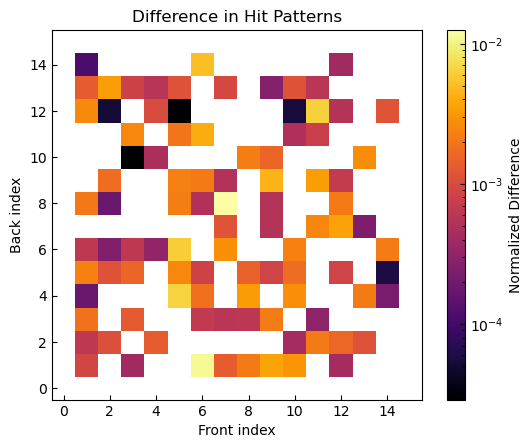

In [23]:
hist1, xedges1, yedges1 = np.histogram2d(p1_fi[0], p1_bi[0], bins=(np.arange(0.5, 17.5, 1), np.arange(0.5, 17.5, 1)))
hist2, xedges2, yedges2 = np.histogram2d(np.array(FI_list[0][1])-0.5, np.array(BI_list[0][1])-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5, 17.5, 1)))

hist1_normalized = hist1 / np.sum(hist1)
hist2_normalized = hist2 / np.sum(hist2)

hist_diff = hist1_normalized - hist2_normalized

plt.figure()
plt.imshow(hist_diff.T, origin='lower', cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.title("Difference in Hit Patterns")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized Difference")
plt.xlabel('Front index')
plt.ylabel('Back index')
plt.show()